In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
def load_data(trace_path):
    with open(trace_path) as json_file:
        json_data = json.load(json_file)

        return json_data

        events = json_data['traceEvents']

        cuda_events = []
        wall_times = []
        timestamps = []

        for event in events:
            if 'stream' in str(event['tid']) and \
                    'name' in event.keys() and \
                    'dur' in event.keys() and \
                    event['cat'] == 'Kernel':
                cuda_events.append(event)
                # print(f"{event['ts']}: {event['dur']}")

                wall_times.append(event['dur'])
                timestamps.append(event['ts'])

        kernel_names = []
        kernel_sum_dur = {}
        kernel_count = {}
        for event in cuda_events:
            kernel_names.append(event['name'])
            kernel_sum_dur[event['name']] = 0
            kernel_count[event['name']] = 0

        kernel_names = np.unique(kernel_names)

        for i in range(len(kernel_names)):
            name = kernel_names[i]
            # print(f'{i}: {kernel_names[i]}')

        for event in cuda_events:
            kernel_sum_dur[event['name']] += event["dur"]
            kernel_count[event['name']] += 1

        for event in cuda_events:
            kernel_sum_dur[event['name']] /= kernel_count[event['name']]


        return {
            "wall_times": wall_times,
            "timestamps": timestamps,
            "kernel_names": kernel_names,
            "kernel_count": kernel_count,
            "kernel_info": kernel_sum_dur
        }

In [50]:
def draw_fixed_model(info):
    profiled_infos = []
    model = info["model"]

    for gpu in info["gpus"]:
        profiled_infos.append({
            "data": load_data(f"{gpu}-{model}-batch-test.json"),
            "gpu": gpu,
        })

    datas = []

    for info in profiled_infos:
        datas.append(info)
        
    print(len(datas[0]["data"]["elapsed_time"]["batch_sizes"]))
    
    gpu = datas[0]["gpu"].split("-")[2]
    plt.figure(figsize=(6,6))
    plt.title(f"model: {model} | gpu: {gpu}")
    ax = plt.subplot(111)
    ax.set_xlabel("batch size")
    ax.set_ylabel("iteration time (ms)")
    
    y_values = []
    for data in datas:
        y_values += data["data"]["elapsed_time"]["forward"]
    y_max = np.max(y_values)

    for data in datas:
        split = data["gpu"].split("-")
        label = f"{split[0]}-{split[1]}"
        
        x = np.array(data["data"]["elapsed_time"]["batch_sizes"])
        x_max = np.max(data["data"]["elapsed_time"]["batch_sizes"])
        x = x / x_max

        y = np.array(data["data"]["elapsed_time"]["forward"])
        #y_max = np.max(data["data"]["elapsed_time"]["iteration_sum"])
        y = y / y_max
        
        ax.plot(x,
                y,
                #data["data"]["elapsed_time"]["forward"],
                '-',
                #color='steelblue',
                label=label)

    ax.legend()
    plt.savefig(f"{model}-batch-sizes-analysis.png", dpi=400)

64


<ipython-input-50-8ccf051a7437>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


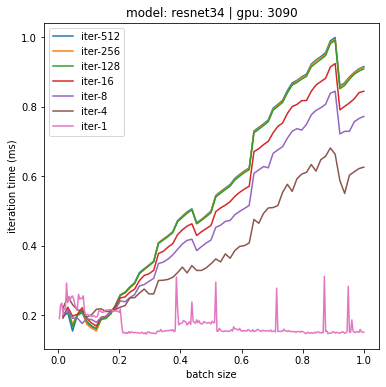

In [51]:
info = {
    "gpus": [
        "iter-512-3090",
        "iter-256-3090",
        "iter-128-3090",
        "iter-16-3090",
        "iter-8-3090",
        "iter-4-3090",
        "iter-1-3090"],
    "model": "resnet34",
}

draw_fixed_model(info)

In [4]:
def draw_iters(info):
    gpu = info["gpu"]
    model = info["model"]

    profiled_info = {
        "data": load_data(f"{gpu}-{model}-batch-test.json"),
        "gpu": gpu,
    }
    
    iters = profiled_info["data"]["elapsed_time"]["iterations"]
    batch_sizes = profiled_info["data"]["elapsed_time"]["batch_sizes"]
    ett = profiled_info["data"]["elapsed_time"]["ett_per_iter"]
    batch_range = len(ett)

    plt.title(f"{model}")
    ax = plt.subplot(111)
    ax.set_xlabel("iteration index")
    ax.set_ylabel("iteration time (ms)")
    for b in range(batch_range):
        ax.plot([i for i in range(iters)],
                ett[b],
                #data["data"]["elapsed_time"]["forward"],
                '-',
                #color='steelblue',
                label=f"batch size: {batch_sizes[b]}")

    ax.legend()
    plt.savefig(f"{model}-batch-sizes-analysis.png", dpi=400)

<ipython-input-8-8aef567104f6>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


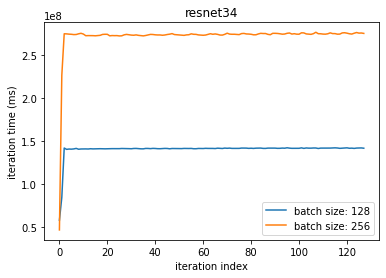

In [9]:
info = {
    "gpu": "inc-3090",
    "model": "resnet34",
}

draw_iters(info)

<ipython-input-8-8aef567104f6>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


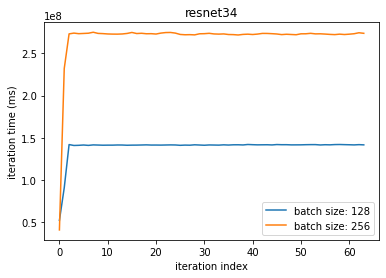

In [10]:
info = {
    "gpu": "inc-64-3090",
    "model": "resnet34",
}

draw_iters(info)

32


<ipython-input-6-73a3042e96d5>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


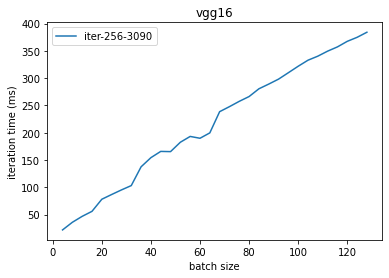

In [53]:
info = {
    "gpus": ["iter-256-3090"],
    "model": "vgg16"#"resnet34",
}

draw_fixed_model(info)

In [15]:
def draw_fixed_gpu(info):
    plt.clf()
    profiled_infos = []
    gpu = info["gpu"]

    for model in info["models"]:
        profiled_infos.append({
            "data": load_data(f"{gpu}-{model}-batch-test.json"),
            "model": model,
        })
        

    plt.title(f"{gpu}")
    ax = plt.subplot(111)
    ax.set_xlabel("batch size")
    ax.set_ylabel("iteration time (ms)")
    for info in profiled_infos:
        ax.plot(info["data"]["elapsed_time"]["batch_sizes"],
                info["data"]["elapsed_time"]["iteration_sum"],
                '-',
                #color='steelblue',
                label=info["model"])

    #ax.plot(data1["data"]["elapsed_time"]["batch_sizes"],
    #        data1["data"]["elapsed_time"]["iteration_sum"],
    #        '-',
    #        color='darkorange',
    #        label=data1["model"])
    ax.legend()
    plt.savefig(f"model-analysis.png", dpi=400)

<ipython-input-15-e418a64b2818>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


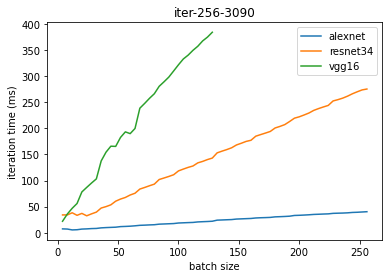

In [16]:
info = {
    "gpu": "iter-256-3090",
    "models": ["alexnet", "resnet34", "vgg16"],
}

draw_fixed_gpu(info)

<ipython-input-11-2dfc35ea7998>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


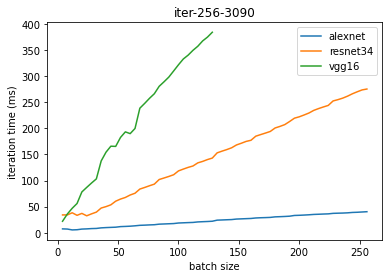

In [12]:
info = {
    "gpu": "iter-256-3090",
    "models": ["alexnet", "resnet34", "vgg16"],
}

draw_fixed_gpu(info)